In [ ]:
import os
import re
import string
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from camel_tools.utils.normalize import normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar


In [2]:
dataset = load_dataset("sem_eval_2018_task_1", 'subtask5.arabic', trust_remote_code=True)

train = dataset['train'].to_pandas()
test = dataset['test'].to_pandas()
valid = dataset['validation'].to_pandas()

In [3]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def split_hashtag_to_words(tag):
    tag = tag.replace('#', '')
    tags = tag.split('_')
    if len(tags) > 1:
        return tags
    else:
        pattern = re.compile(r"[\u0621-\u064A]+|\d+")
        return pattern.findall(tag)

def is_hashtag(word):
    return word.startswith("#")

def extract_hashtag(text):
    hash_list = [re.sub(r"(\W+)$", "", i) for i in text.split() if i.startswith("#")]
    word_list = []
    for word in hash_list:
        word_list.extend(split_hashtag_to_words(word))
    return word_list

def clean_hashtag(text):
    words = text.split()
    cleaned = []
    for word in words:
        if is_hashtag(word):
            cleaned.extend(extract_hashtag(word))
        else:
            cleaned.append(word)
    return " ".join(cleaned)

def ortho_normalize(text):
    text = normalize_alef_maksura_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_teh_marbuta_ar(text)
    return text

def processPost(tweet):
    tweet = re.sub('@[^\s]+', ' ', tweet)
    tweet = re.sub('#\d+K\d+', ' ', tweet)
    tweet = re.sub('http\S+\s*', ' ', tweet)
    tweet = re.sub('RT|cc', ' ', tweet)
    tweet = re.sub(r'[a-zA-Z0-9]', ' ', tweet)
    tweet = clean_hashtag(tweet)
    tweet = remove_punctuations(tweet)
    tweet = ortho_normalize(tweet)
    tweet = re.sub('\s+', ' ', tweet)
    return tweet.strip()


<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\S'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\S'
<>:53: SyntaxWarning: invalid escape sequence '\s'
C:\Users\CLICK ONCE\AppData\Local\Temp\ipykernel_21592\1222993561.py:45: SyntaxWarning: invalid escape sequence '\s'
  tweet = re.sub('@[^\s]+', ' ', tweet)
C:\Users\CLICK ONCE\AppData\Local\Temp\ipykernel_21592\1222993561.py:46: SyntaxWarning: invalid escape sequence '\d'
  tweet = re.sub('#\d+K\d+', ' ', tweet)
C:\Users\CLICK ONCE\AppData\Local\Temp\ipykernel_21592\1222993561.py:47: SyntaxWarning: invalid escape sequence '\S'
  tweet = re.sub('http\S+\s*', ' ', tweet)
C:\Users\CLICK ONCE\AppData\Local\Temp\ipykernel_21592\1222993561.py:53: SyntaxWarning: invalid escape sequence '\s'


In [4]:
def preprocess_dataframe(df):
    df = df.copy()
    
    # Apply core preprocessing
    df['text'] = df['Tweet'].astype(str).apply(processPost)
    
    # Remove empty, whitespace-only or duplicate texts
    df = df[df['text'].str.strip() != '']
    df = df.drop_duplicates(subset='text')
    
    # Remove rows where all emotion labels are missing
    label_columns = [col for col in df.columns if col not in ['Tweet', 'text']]
    df = df[~df[label_columns].isnull().all(axis=1)]
    
    # Filter: keep texts with >3 words
    df = df[df['text'].apply(lambda x: len(x.split()) > 3)]
    
    return df[['text'] + label_columns]


In [5]:
train_clean = preprocess_dataframe(train)
test_clean = preprocess_dataframe(test)
valid_clean = preprocess_dataframe(valid)

os.makedirs("datasets", exist_ok=True)
train_clean.to_csv("datasets/train_dataset.csv", index=False)
test_clean.to_csv("datasets/test_dataset.csv", index=False)
valid_clean.to_csv("datasets/valid_dataset.csv", index=False)

print("✅ All datasets preprocessed and saved successfully.")


✅ All datasets preprocessed and saved successfully.


In [11]:
def visualize_data(original_dfs, cleaned_dfs):
    with open("log.txt", "w", encoding="utf-8") as f:
        f.write("==== Dataset Shapes ====\n")
        for key in original_dfs:
            f.write(f"{key} - Original shape: {original_dfs[key].shape}\n")
            f.write(f"{key} - Cleaned shape: {cleaned_dfs[key].shape}\n")

    train_key = "datasets/train_dataset.csv"
    
    if train_key in cleaned_dfs:
        with open("log.txt", "a", encoding="utf-8") as f:
            f.write("\n==== Detailed view for train_dataset.csv ====\n")
            f.write("\nFirst 5 rows before cleaning:\n")
            f.write(original_dfs[train_key].head().to_string())
            f.write("\n\nFirst 5 rows after cleaning:\n")
            f.write(cleaned_dfs[train_key].head().to_string())

        # Word count distribution
        cleaned_dfs[train_key]['word_count'] = cleaned_dfs[train_key]['text'].apply(lambda x: len(x.split()))
        plt.figure(figsize=(10, 6))
        sns.histplot(cleaned_dfs[train_key]['word_count'], bins=30, kde=True)
        plt.title('Word Count Distribution - Train Dataset')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.show()

        # Label distribution
        # Label distribution (ensure numeric types)
        label_columns = [col for col in cleaned_dfs[train_key].columns if col not in ['text', 'word_count']]
        for col in label_columns:
            cleaned_dfs[train_key][col] = pd.to_numeric(cleaned_dfs[train_key][col], errors='coerce')
        label_counts = cleaned_dfs[train_key][label_columns].sum().sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=label_counts.index, y=label_counts.values)
        plt.title('Label Distribution - Train Dataset')
        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

        # Most common words
        all_words = ' '.join(cleaned_dfs[train_key]['text']).split()
        word_freq = Counter(all_words)
        common_words = word_freq.most_common(20)
        words, counts = zip(*common_words)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(words), y=list(counts))
        plt.title('Top 20 Words - Train Dataset')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()

    # ==== Comparative Visualizations ====
    plt.figure(figsize=(12, 6))
    for key in cleaned_dfs:
        cleaned_dfs[key]['word_count'] = cleaned_dfs[key]['text'].apply(lambda x: len(x.split()))
        sns.kdeplot(cleaned_dfs[key]['word_count'], label=key.split('/')[-1].replace("_dataset.csv", "").capitalize(), fill=True)
    plt.title('Word Count Distribution Across Datasets')
    plt.xlabel('Word Count')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    all_label_counts = []
    for key in cleaned_dfs:
        label_cols = [col for col in cleaned_dfs[key].columns if col not in ['text', 'word_count']]
        if label_cols:
            for col in label_cols:
                cleaned_dfs[key][col] = pd.to_numeric(cleaned_dfs[key][col], errors='coerce')
            counts = cleaned_dfs[key][label_cols].sum()
            for label, count in counts.items():
                all_label_counts.append({
                    'Dataset': key.split('/')[-1].replace("_dataset.csv", "").capitalize(),
                    'Label': label,
                    'Count': count
                })
    df_labels = pd.DataFrame(all_label_counts)

    if not df_labels.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_labels, x='Label', y='Count', hue='Dataset')
        plt.title('Label Distribution Comparison')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Dataset')
        plt.show()


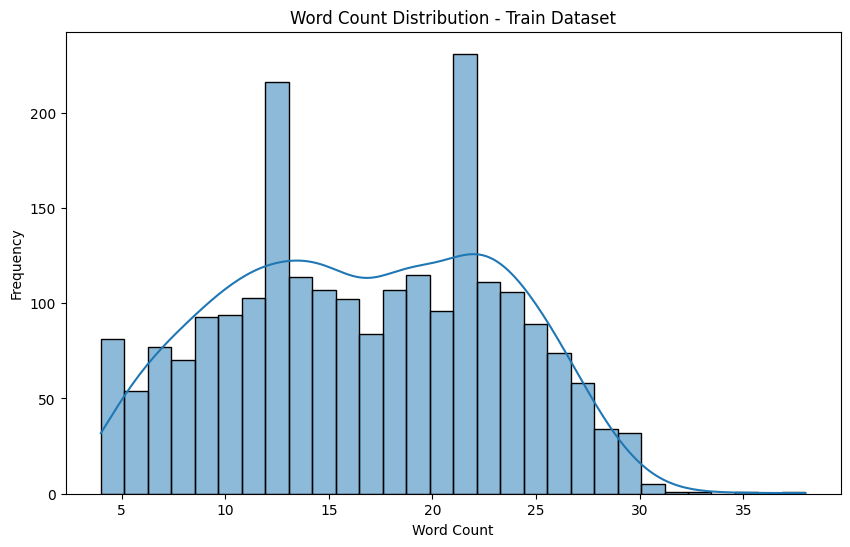

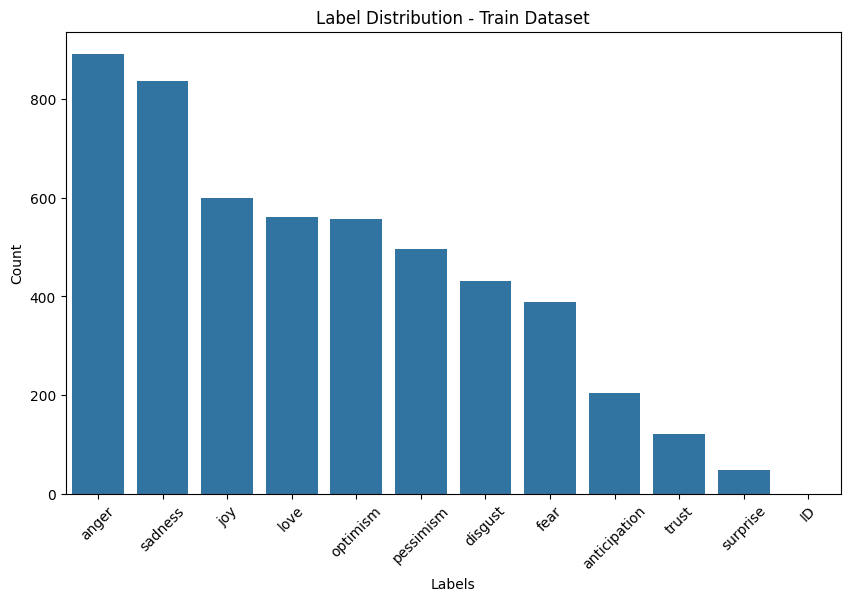

C:\Users\CLICK ONCE\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


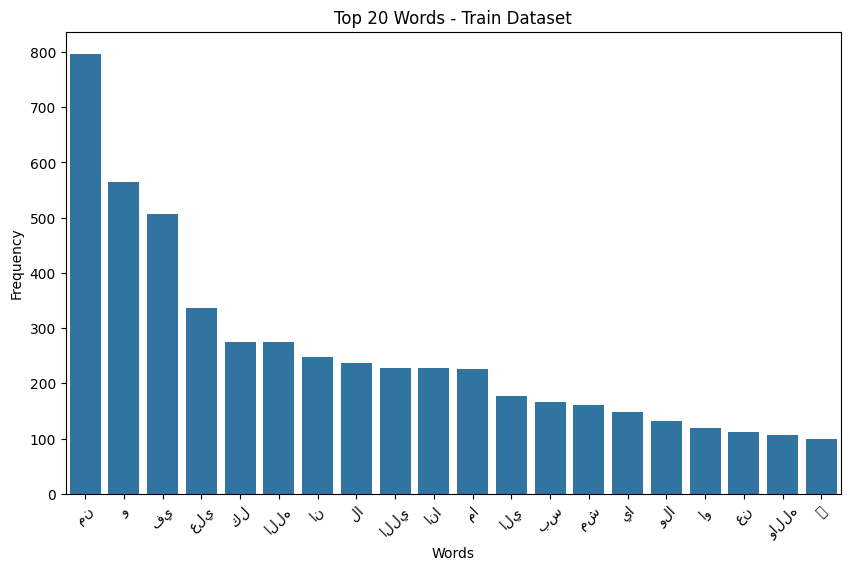

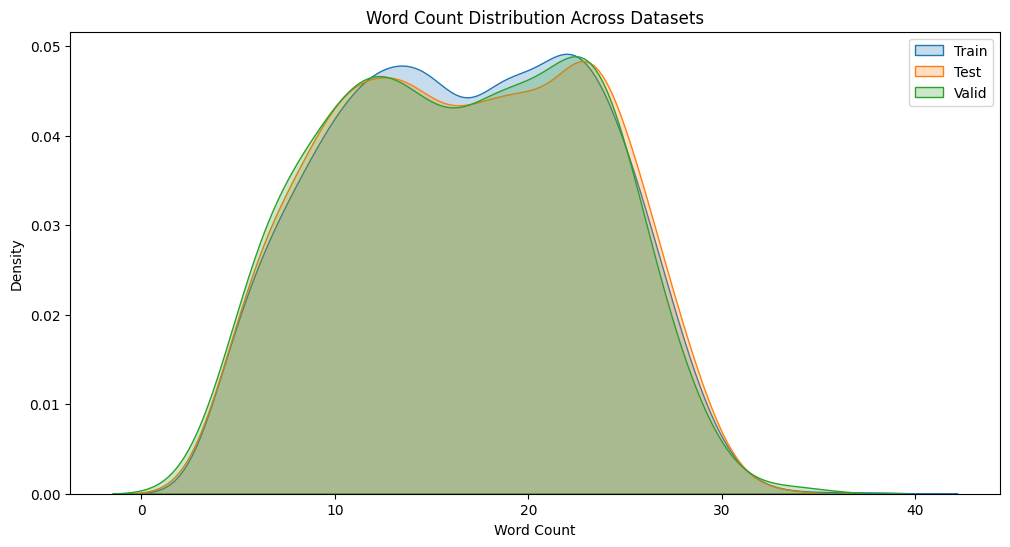

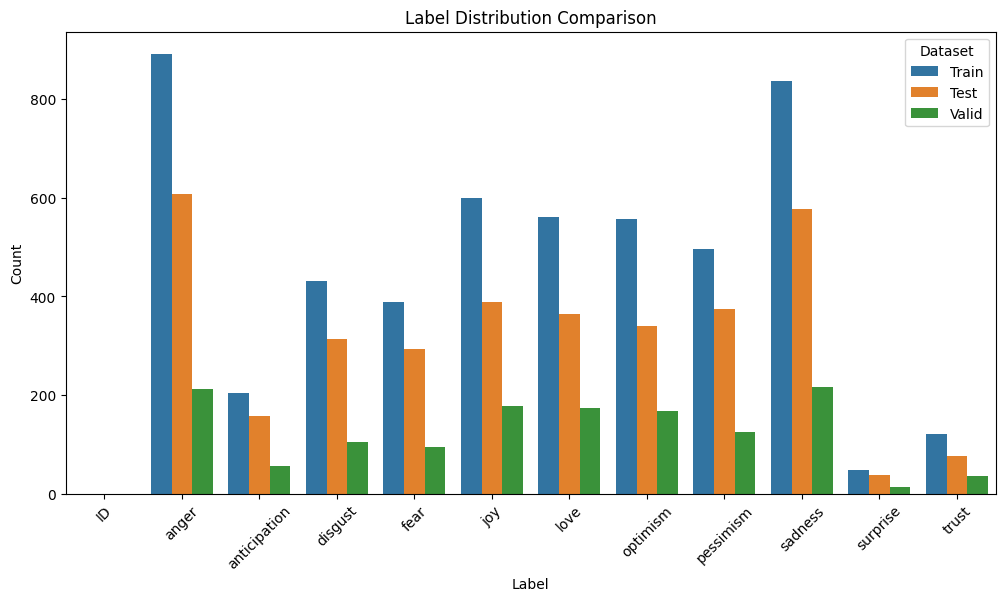

In [12]:
original_dfs = {
    "datasets/train_dataset.csv": train,
    "datasets/test_dataset.csv": test,
    "datasets/valid_dataset.csv": valid
}

cleaned_dfs = {
    "datasets/train_dataset.csv": train_clean,
    "datasets/test_dataset.csv": test_clean,
    "datasets/valid_dataset.csv": valid_clean
}

visualize_data(original_dfs, cleaned_dfs)

In [14]:
import pandas as pd
train_df = pd.read_csv('datasets/train_dataset.csv')
test_df = pd.read_csv('datasets/test_dataset.csv')
validation_df = pd.read_csv('datasets/valid_dataset.csv')

In [15]:
train_df.columns

Index(['text', 'ID', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

### **Data preparation**

In [ ]:
import numpy as np
MAX_LENGTH = 64
X_train_input_ids = np.zeros((len(train_df), MAX_LENGTH))
X_train_attn_masks = np.zeros((len(train_df), MAX_LENGTH))

X_test_input_ids = np.zeros((len(test_df), MAX_LENGTH))
X_test_attn_masks = np.zeros((len(test_df), MAX_LENGTH))

X_validation_input_ids = np.zeros((len(validation_df), MAX_LENGTH))
X_validation_attn_masks = np.zeros((len(validation_df), MAX_LENGTH))

In [ ]:
from tqdm import tqdm

def generate_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [20]:

from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("aubmindlab/bert-large-arabertv02-twitter")

In [21]:
X_train_input_ids, X_train_attn_masks = generate_data(train_df, X_train_input_ids, X_train_attn_masks, tokenizer) 

X_test_input_ids, X_test_attn_masks = generate_data(test_df, X_test_input_ids, X_test_attn_masks, tokenizer) 

X_validation_input_ids, X_validation_attn_masks = generate_data(validation_df, X_validation_input_ids, X_validation_attn_masks, tokenizer) 

2257it [00:15, 141.99it/s]
1507it [00:00, 2759.03it/s]
580it [00:00, 2751.77it/s]


In [22]:
X_train_input_ids

array([[2.0000e+00, 1.8440e+03, 8.8000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 4.5900e+02, 2.4276e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.9031e+04, 2.7083e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+00, 1.9550e+03, 7.2410e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.2949e+04, 6.6900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 1.6038e+04, 2.0900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [23]:
train_labels = np.zeros((len(train_df), 11))
test_labels = np.zeros((len(test_df), 11))
validation_labels = np.zeros((len(validation_df), 11))

In [24]:
labels_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']  
train_labels = train_df[labels_names].values.astype('int8')
test_labels = test_df[labels_names].values.astype('int8')
validation_labels = validation_df[labels_names].values.astype('int8')

In [25]:
train_labels

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int8)

In [26]:
import tensorflow as tf
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_attn_masks, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attn_masks, test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation_input_ids, X_validation_attn_masks, validation_labels))

In [27]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [28]:
BATCH_SIZE = 32
train_dataset = train_dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True) # batch size, drop any left out tensor
validation_dataset = validation_dataset.map(SentimentDatasetMapFunction)
validation_dataset = validation_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=False)

### **Model**

In [29]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained("aubmindlab/bert-base-arabertv02-twitter", from_pt=True) # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

In [30]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='attention_mask', dtype='int32')

In [31]:
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
# base = model.bert(input_ids, attention_mask=attn_masks)
# bert_embds = base.pooler_output

In [32]:
intermediate_layer = tf.keras.layers.Dense(64, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(11, activation='sigmoid', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

In [33]:
emotion_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
emotion_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1351933   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 64, 76                                       

### **Train**

Without scheduler

In [34]:
optim = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_func = tf.keras.losses.BinaryCrossentropy()

In [35]:
emotion_model.compile(optimizer=optim, loss=loss_func)

with early stopping

In [36]:
NUM_EPOCHS = 20

# Define the early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
  history = emotion_model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=NUM_EPOCHS,
      callbacks=[early_stopping_callback]
  )

Epoch 1/20

70/70 [==============================] - 1219s 17s/step - loss: 0.4247 - val_loss: 0.3294
Epoch 2/20
70/70 [==============================] - 1157s 17s/step - loss: 0.2875 - val_loss: 0.2905
Epoch 3/20
70/70 [==============================] - 1024s 15s/step - loss: 0.2344 - val_loss: 0.2716
Epoch 4/20
70/70 [==============================] - 988s 14s/step - loss: 0.1979 - val_loss: 0.2652
Epoch 5/20
70/70 [==============================] - 913s 13s/step - loss: 0.1699 - val_loss: 0.2772
Epoch 6/20
70/70 [==============================] - 998s 14s/step - loss: 0.1444 - val_loss: 0.2784
Epoch 7/20
70/70 [==============================] - 1139s 16s/step - loss: 0.1201 - val_loss: 0.2920


In [37]:
from sklearn.metrics import jaccard_score

# Generate predictions on test set
test_preds = emotion_model.predict([X_test_input_ids, X_test_attn_masks])
test_preds[test_preds >= 0.5] = 1
test_preds[test_preds < 0.5] = 0

48/48 [==============================] - 294s 6s/step


In [38]:
# Compute Jaccard index
jaccard_index = jaccard_score(test_labels, test_preds, average='weighted')

print('Jaccard index:', jaccard_index)

Jaccard index: 0.5553929945121211


### Data Importation

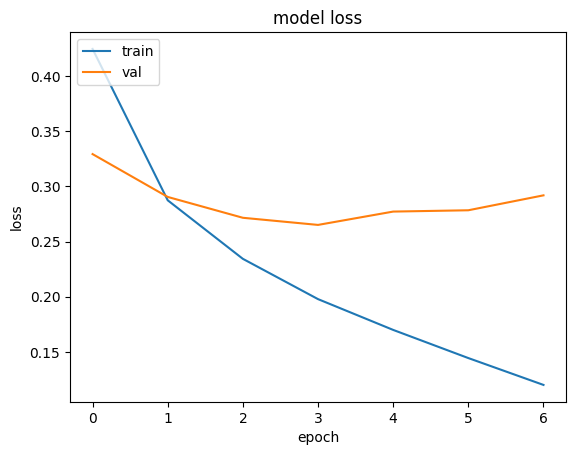

In [40]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
# Save the model as an H5 file
emotion_model.save('emotion_model/emotion_model.h5')
emotion_model.save("emotion_model")

c:\Users\CLICK ONCE\AppData\Local\Programs\Python\Python312\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: emotion_model\assets


INFO:tensorflow:Assets written to: emotion_model\assets


In [42]:
import numpy as np

# Define Arabic text examples
arabic_examples = [
    'أنا سعيد جدًا بالنجاح الذي حققته في عملي، وأشعر بالتفاؤل للمستقبل.',
    'أشعر بالخوف والحزن بسبب الوضع الراهن والتحديات التي نواجهها.',
    'لم يكن العمل بالنسبة لي مجرد وظيفة، بل كان يمثل شغفي وحبي.',
    'شعرت بالاشمئزاز من تصرفات بعض الأشخاص وسلوكهم السيء.',
    'أنا متحمس للاحتفال بعيد ميلادي الذي سيحل قريبًا وأشعر بالفرحة.',
    'أنا أحب عائلتي وأقدر الحب الذي يبادلوني إياه.',
    'كنت مترددًا في بداية الأمر لكني الآن أشعر بالثقة والتفاؤل لتحقيق الهدف.',
    'أشعر بالغضب بسبب الظلم الذي يتعرض له بعض الأفراد في المجتمع.',
    'شعرت بالدهشة عندما سمعت الخبر السار والذي لم أكن أتوقعه.',
    'أنا متأكد من صدق ووفاء صديقي العزيز وأشعر بالثقة تجاهه.'
]

# Loop through Arabic examples and make predictions
for i, text in enumerate(arabic_examples):
    # Tokenize input sentence
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=64, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )

    # Get input_ids and attention_mask from tokenized text
    input_ids = tokenized_text.input_ids
    attention_mask = tokenized_text.attention_mask

    # Make predictions on tokenized input
    preds = emotion_model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Convert probabilities to binary predictions
    binary_preds = (preds >= 0.5).astype(int)

    # Get predicted labels
    predicted_labels = np.array(labels_names)[binary_preds[0] == 1]

    # Print predicted labels and expected labels for each example
    print('Example {}:'.format(i+1))
    print('Input Text: {}'.format(text))
    print('Predicted Labels: {}'.format(predicted_labels))

1/1 [==============================] - 4s 4s/step
Example 1:
Input Text: أنا سعيد جدًا بالنجاح الذي حققته في عملي، وأشعر بالتفاؤل للمستقبل.
Predicted Labels: ['joy' 'optimism']
1/1 [==============================] - 0s 206ms/step
Example 2:
Input Text: أشعر بالخوف والحزن بسبب الوضع الراهن والتحديات التي نواجهها.
Predicted Labels: ['fear' 'sadness']
1/1 [==============================] - 0s 187ms/step
Example 3:
Input Text: لم يكن العمل بالنسبة لي مجرد وظيفة، بل كان يمثل شغفي وحبي.
Predicted Labels: []
1/1 [==============================] - 0s 208ms/step
Example 4:
Input Text: شعرت بالاشمئزاز من تصرفات بعض الأشخاص وسلوكهم السيء.
Predicted Labels: ['anger' 'disgust' 'pessimism' 'sadness']
1/1 [==============================] - 0s 182ms/step
Example 5:
Input Text: أنا متحمس للاحتفال بعيد ميلادي الذي سيحل قريبًا وأشعر بالفرحة.
Predicted Labels: ['joy' 'love' 'optimism']
1/1 [==============================] - 0s 228ms/step
Example 6:
Input Text: أنا أحب عائلتي وأقدر الحب الذي يبادلوني إياه.

In [43]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds, target_names=labels_names))


              precision    recall  f1-score   support

       anger       0.77      0.84      0.81       607
anticipation       0.47      0.18      0.26       158
     disgust       0.59      0.61      0.60       314
        fear       0.83      0.69      0.75       293
         joy       0.90      0.76      0.82       388
        love       0.85      0.75      0.80       364
    optimism       0.81      0.76      0.78       340
   pessimism       0.49      0.50      0.50       375
     sadness       0.75      0.78      0.77       577
    surprise       0.00      0.00      0.00        38
       trust       0.50      0.04      0.07        76

   micro avg       0.74      0.68      0.71      3530
   macro avg       0.63      0.54      0.56      3530
weighted avg       0.73      0.68      0.69      3530
 samples avg       0.75      0.72      0.69      3530



c:\Users\CLICK ONCE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CLICK ONCE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CLICK ONCE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

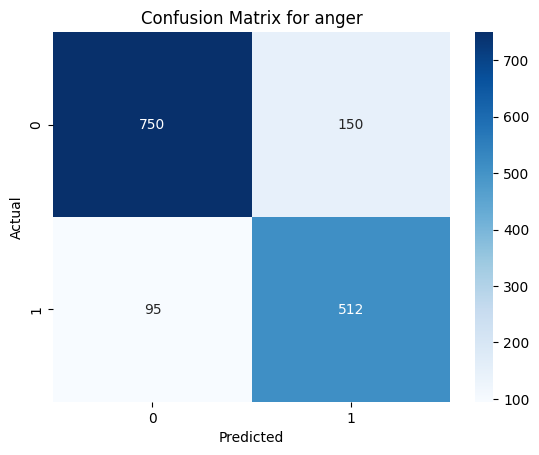

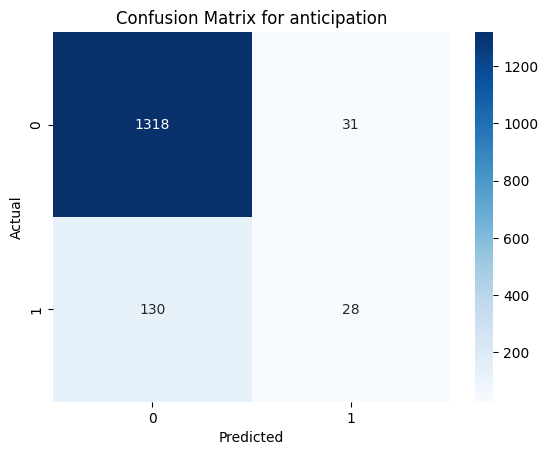

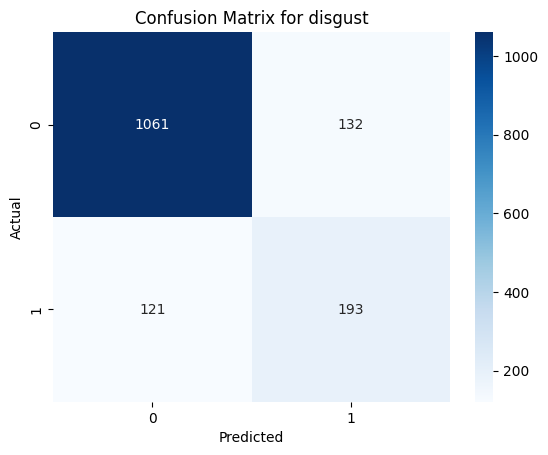

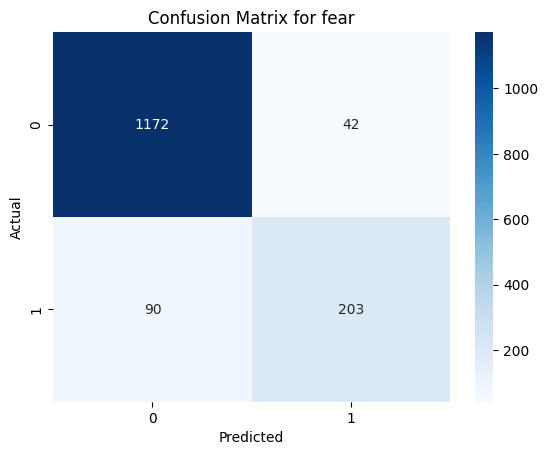

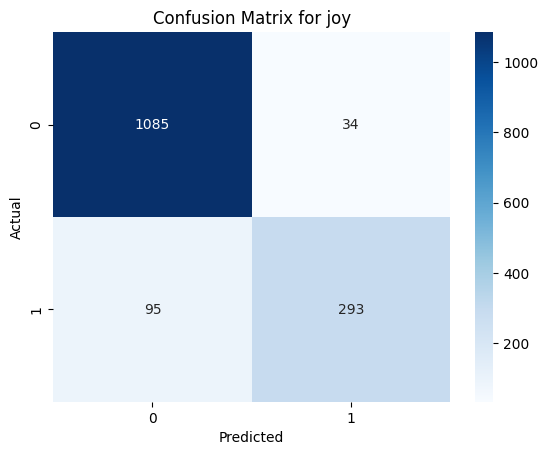

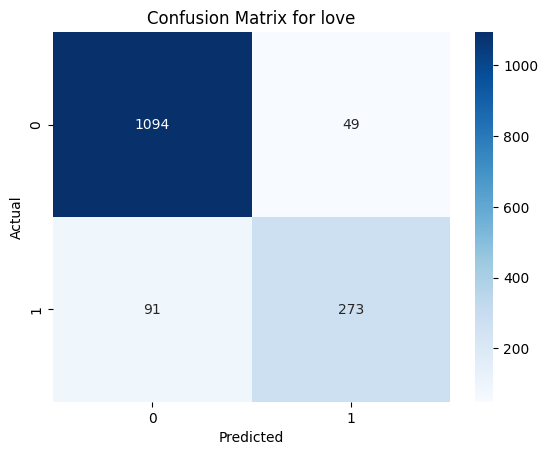

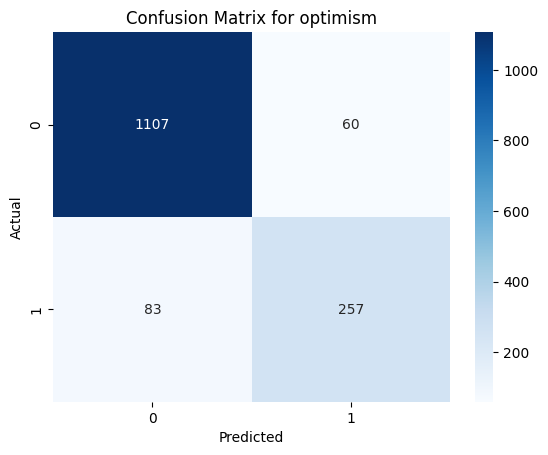

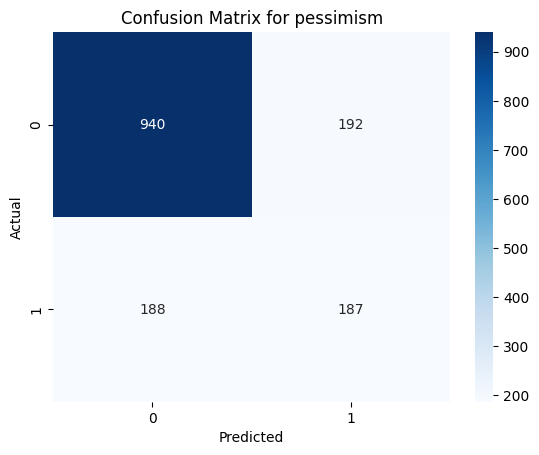

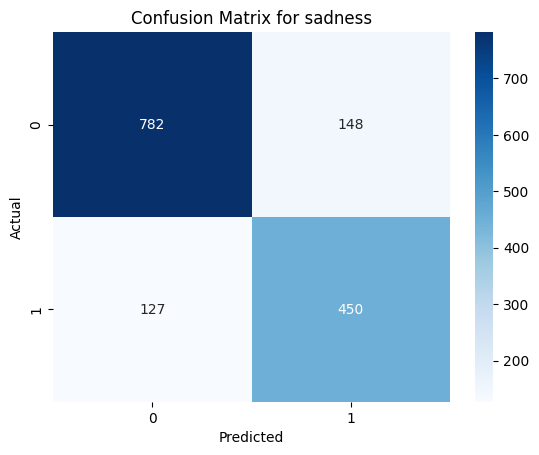

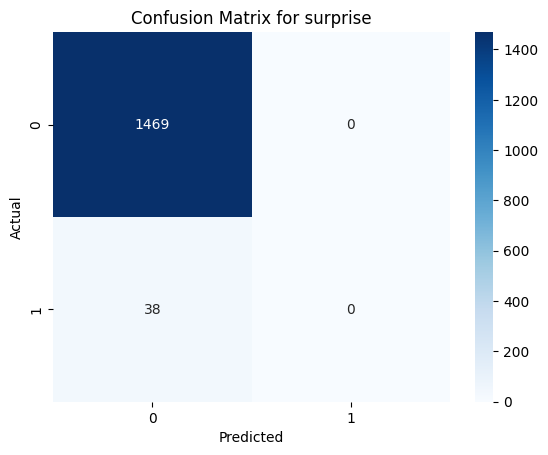

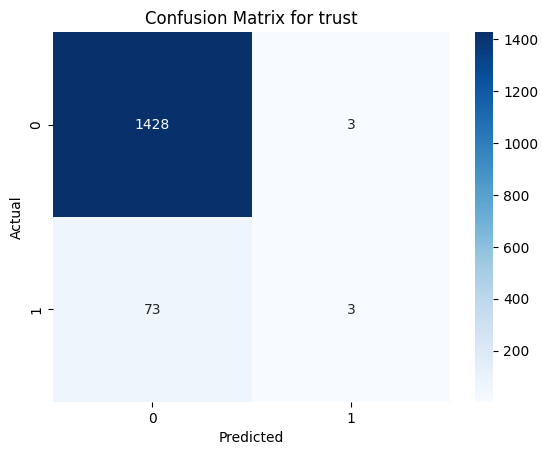

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(test_labels, test_preds)

for i in range(len(labels_names)):
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {labels_names[i]}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [45]:
from sklearn.metrics import hamming_loss

print("Hamming Loss:", hamming_loss(test_labels, test_preds))

Hamming Loss: 0.11896000482596368


In [46]:
from sklearn.metrics import accuracy_score

print("Subset Accuracy:", accuracy_score(test_labels, test_preds))

Subset Accuracy: 0.2707365627073656


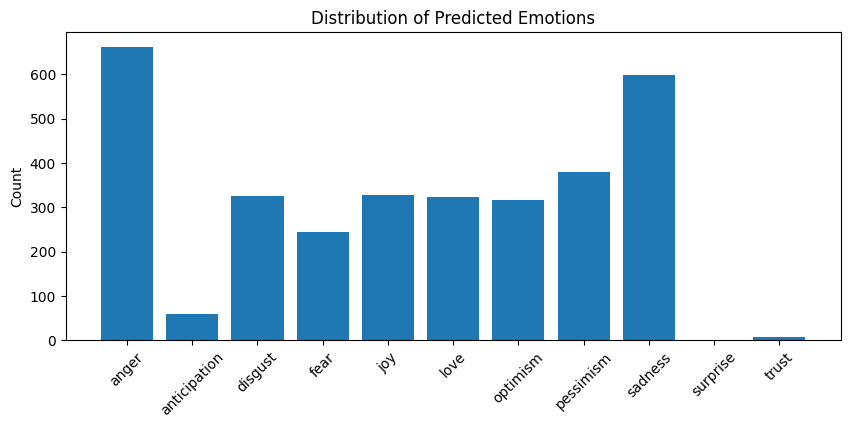

In [47]:
import numpy as np

# Count how often each emotion is predicted
emotion_counts = np.sum(test_preds, axis=0)

plt.figure(figsize=(10, 4))
plt.bar(labels_names, emotion_counts)
plt.title("Distribution of Predicted Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(y_true, y_pred, class_names):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

In [49]:
def show_misclassified_examples(X, y_true, y_pred, class_names, target_class):
    idx = class_names.index(target_class)
    fp_indices = np.where((y_true[:, idx] == 0) & (y_pred[:, idx] == 1))[0]
    fn_indices = np.where((y_true[:, idx] == 1) & (y_pred[:, idx] == 0))[0]

    print(f"\nFalse Positives for {target_class} (Predicted but not true):")
    for i in fp_indices[:5]:
        print(f"\nSample {i}:\n{X[i]}")

    print(f"\nFalse Negatives for {target_class} (True but not predicted):")
    for i in fn_indices[:5]:
        print(f"\nSample {i}:\n{X[i]}")

In [50]:
def show_topk_predictions(y_true, y_pred_probs, class_names, k=3, sample_indices=None):
    y_pred_topk = np.argsort(-y_pred_probs, axis=1)[:, :k]
    if sample_indices is None:
        sample_indices = np.random.choice(len(y_true), size=5, replace=False)

    for idx in sample_indices:
        true_labels = [class_names[i] for i in np.where(y_true[idx])[0]]
        pred_labels = [class_names[i] for i in y_pred_topk[idx]]
        print(f"\nSample {idx}:")
        print(f"✅ True: {true_labels}")
        print(f"🤖 Top-{k} Predicted: {pred_labels}")

In [51]:

show_misclassified_examples(train_labels, test_labels, test_preds, labels_names, target_class='sadness')


False Positives for sadness (Predicted but not true):

Sample 29:
[1 0 1 0 0 0 0 0 1 0 0]

Sample 30:
[0 0 0 0 1 0 1 0 0 0 1]

Sample 45:
[1 0 0 0 0 0 0 0 1 0 0]

Sample 46:
[0 0 0 0 1 1 1 0 0 0 0]

Sample 49:
[0 0 0 0 1 1 1 0 0 0 0]

False Negatives for sadness (True but not predicted):

Sample 2:
[0 0 0 0 0 1 1 0 0 0 0]

Sample 9:
[0 0 0 1 0 0 0 0 0 0 0]

Sample 21:
[0 0 0 0 1 1 0 0 0 0 1]

Sample 22:
[1 0 0 0 0 0 0 1 0 0 0]

Sample 28:
[0 0 0 1 0 0 0 0 1 0 0]
